## Data Science Regression Project: Predicting Home Prices in Banglore

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load: Load banglore home prices into a dataframe

In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()


Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

#### Drop features that are not required to build our model

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

## Data Cleaning: Handle NA values

In [8]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2.shape

(13320, 5)

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## Feature Engineering

#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\HP\AppData\Local\Temp/ipykernel_11112/2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

#### Explore total_sqft feature

In [12]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [13]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


#### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [14]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None  

In [15]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


#### For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [16]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [17]:
(2100+2850)/2

2475.0

#### Add new feature called price per square feet

In [18]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [19]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

#### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [20]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [21]:
location_stats.values.sum()

13200

In [22]:
len(location_stats[location_stats>10])

240

In [23]:
len(location_stats)

1287

In [24]:
len(location_stats[location_stats<=10])

1047

## Dimensionality Reduction

#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1047, dtype: int64

In [27]:
len(df5.location.unique())

1287

In [28]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [29]:
df5.head(3)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556


## Outlier Removal Using Business Logic

####  Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft.

In [30]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


#### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [31]:
df5.shape

(13200, 7)

In [32]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

Text(0, 0.5, 'Count')

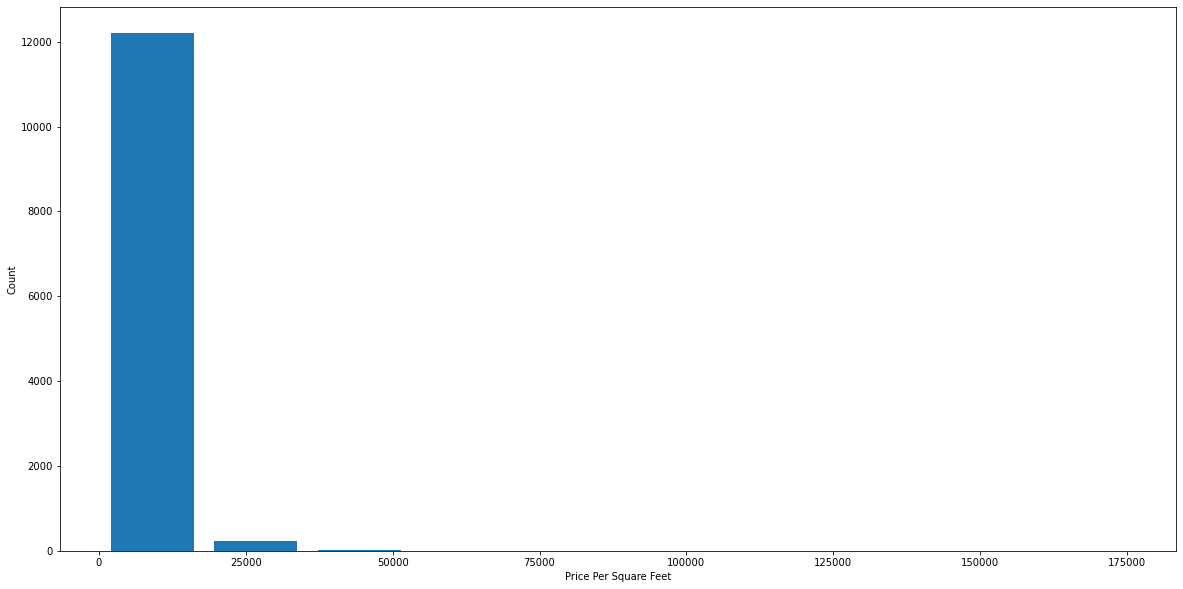

In [33]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier Removal Using Bathrooms Feature

In [34]:
df6.bath.unique()

array([ 2.,  5.,  3.,  4.,  1.,  8.,  6.,  7.,  9., 14., 12., 16., 10.,
       13.])

Text(0, 0.5, 'Count')

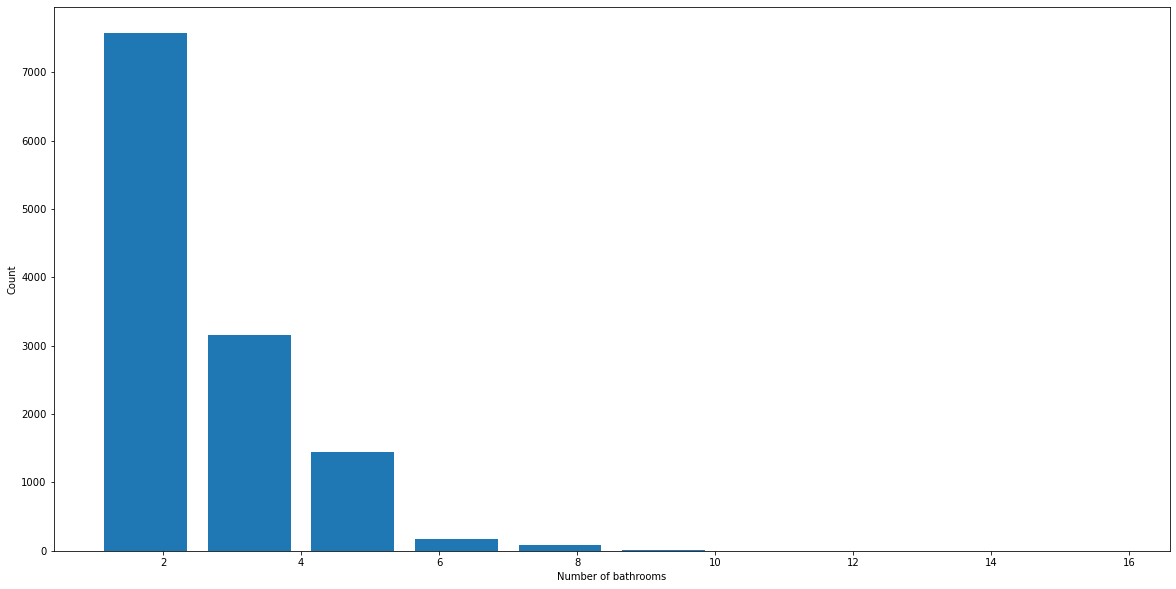

In [36]:
plt.hist(df6.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [40]:
df6[df6.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1078,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
3096,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
3609,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
7979,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
8636,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
9935,other,13 BHK,5425.0,13.0,275.0,13,5069.124424
13067,other,10 Bedroom,7150.0,13.0,3600.0,10,50349.650350


#### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [41]:
df6[df6.bath>df6.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1078,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
2620,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
6838,Rajaji Nagar,5 BHK,7500.0,8.0,1700.0,5,22666.666667
7709,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
9974,other,3 Bedroom,2400.0,6.0,775.0,3,32291.666667
11366,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
12103,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
12443,other,4 Bedroom,4350.0,8.0,2600.0,4,59770.114943
13067,other,10 Bedroom,7150.0,13.0,3600.0,10,50349.650350


#### if we have 4 bedroom home and even if we have bathroom in all 4 rooms plus one guest bathroom, we will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed.

In [42]:
df7 = df6[df6.bath<df6.bhk+2]
df7.shape

(12303, 7)

In [44]:
df7.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [46]:
df8 = df7.drop(['size','price_per_sqft'],axis='columns')
df8.head(3)

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3


## Use One Hot Encoding For Location

In [48]:
dummies = pd.get_dummies(df8.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df9 = pd.concat([df8,dummies.drop('other',axis='columns')],axis='columns')
df9.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,Electronic City Phase II,1056.0,2.0,39.07,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chikka Tirupathi,2600.0,5.0,120.00,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Uttarahalli,1440.0,2.0,62.00,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Lingadheeranahalli,1521.0,3.0,95.00,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kothanur,1200.0,2.0,51.00,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df10 = df9.drop('location',axis='columns')
df10.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2.0,39.07,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2600.0,5.0,120.00,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build a Linear Regression Model 

In [51]:
df10.shape

(12303, 244)

In [53]:
X = df10.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1056.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2600.0,5.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1440.0,2.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X.shape

(12303, 243)

In [56]:
y = df10.price
y.head(3)

0     39.07
1    120.00
2     62.00
Name: price, dtype: float64

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.10,random_state = 19)

In [77]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.6332077040691115

In [82]:
y_pred = lr_clf.predict(X_test)

In [83]:
from sklearn import metrics
lr_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', lr_MAE)
                                         
# calculate MSE
lr_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', lr_MSE)
                                         
# calculate RMSE
lr_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', lr_RMSE)

Mean Absolute Error (MAE): 36.20213019528565
Mean Squared Error (MSE): 5629.063278678316
Root Mean Squared Error (RMSE): 75.0270836343671


## Use K Fold cross validation to measure accuracy of our LinearRegression model

In [80]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([ 0.4891095 ,  0.49734726, -0.05754908,  0.30595316,  0.48753056,
        0.40938694,  0.50612099,  0.47337364,  0.48013987,  0.41902142])

## Decision Tree Model

In [84]:
from sklearn.tree import DecisionTreeRegressor

dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(dt.score(X_test,y_test))

0.25512119077381146


In [87]:
y_pred = dt.predict(X_test)

In [88]:
dt_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', dt_MAE)
                                         
# calculate MSE
dt_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', dt_MSE)
                                         
# calculate RMSE
dt_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', dt_RMSE)

Mean Absolute Error (MAE): 35.19186836743252
Mean Squared Error (MSE): 11431.455890967827
Root Mean Squared Error (RMSE): 106.91798675137794


## Random Forest Regression Model

In [89]:
from sklearn.ensemble import RandomForestRegressor

rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(rf.score(X_test,y_test))

0.4553280573857378


In [90]:
y_pred = rf.predict(X_test)

In [91]:
rf_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_MAE)
                                         
# calculate MSE
rf_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_MSE)
                                         
# calculate RMSE
rf_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_RMSE)

Mean Absolute Error (MAE): 31.23681242536092
Mean Squared Error (MSE): 8358.934648054948
Root Mean Squared Error (RMSE): 91.42720956069341


## Hyper parameter tunning with grid serch cv

In [92]:
paramaters = [{'n_estimators': [ 85, 100],
                     'min_samples_split': [15,20],
                     'max_depth': [8, 10],
                     'min_samples_leaf': [5,10],
                     'max_leaf_nodes': [10, 15]
                    }]

In [93]:
from sklearn.model_selection import GridSearchCV
rf_reg_CV= RandomForestRegressor(random_state = 10)
grid = GridSearchCV(estimator = rf_reg_CV, 
                         param_grid = paramaters, 
                         cv = 5)
rf_grid = grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest regressor: ', rf_grid.best_params_, '\n')

Best parameters for random forest regressor:  {'max_depth': 8, 'max_leaf_nodes': 15, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 85} 



## Build the model using the hyperparameters

In [101]:
rf_grid =  RandomForestRegressor(n_estimators=150,
    max_depth=8,
    min_samples_split=15,
    min_samples_leaf=10,
    max_leaf_nodes=15,
    )
rf_grid.fit(X_train, y_train)
rf_grid_pred = rf_grid.predict(X_test)
print(rf_grid.score(X_test,y_test))

0.5972567939184827


#### Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

In [102]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [103]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

96.99164576783184

In [104]:
predict_price('Indira Nagar',1000, 2, 2)

203.35381501280816

## Export the tested model to a pickle file

In [105]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)